In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ticktack
from ticktack import fitting
import os
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

In [2]:
lat = [50 + 18/60, 48 + 43/60, 63 + 9/60, 48 + 48/60, 
      54 + 28/60, 40 + 6/60, 67 + 29/60, 31 + 7/60, 
      37 + 27/60, 30 + 20/60, 72 + 13/60, 35 + 57/60, 
      46 + 40/60, 69, 58 +38/60, 48 + 10/60,
      67 + 31/60, 37 + 77/60, 35 + 10/60, 68 + 15/60, 68.5]
events = ["Büntgen18_ALT01", "Büntgen18_GER01", 
          "Büntgen18_SWE05", "Büntgen18_GER07",
          "Büntgen18_CAN06", "Büntgen18_GRE02", 
          "Büntgen18_RUS04", "Büntgen18_TIB01",
          "Büntgen18_CHN01", "Büntgen18_JAP01", 
          "Büntgen18_RUS15", "Büntgen18_USA02",
          "Büntgen18_MON03", 
          "Büntgen18_RUS17", "Büntgen18_USA11",
          "Büntgen18_MON09", 
          "Büntgen18_RUS20", "Büntgen18_USA18",
          "Büntgen18_PAK04", 
          "Büntgen18_SWE02", "Uusitalo18_Pine"]
events_lat = dict(zip(events, lat))  

In [3]:
cbm_models = ["Guttler15", "Buntgen18", "Brehm21",]
steady_state = []
for cbm_model in cbm_models:
    sf = fitting.SingleFitter(cbm_model, cbm_model=cbm_model)
    steady_state.append(sf.steady_state_production)

INFO[2022-02-20 12:32:20,219]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-02-20 12:32:20,220]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-02-20 12:32:20,222]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-02-20 12:32:20,223]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
Guttler14 = np.zeros((6000, len(events)))
Buntgen18 = np.zeros((6000, len(events)))
Brehm21 = np.zeros((6000, len(events)))

In [5]:
units = "atoms"
if units == "atoms":
    conversion = 1
else:
    conversion = 14.003242 / 6.022 * 5.11 * 31536. / 1e5 
for i, event in enumerate(events):
    Guttler14[:, i] = np.load("individual_chain/{}_Guttler15.npy".format(event))[:, 2] * conversion
for i, event in enumerate(events):
    Buntgen18[:, i] = np.load("individual_chain/{}_Buntgen18.npy".format(event))[:, 2] * conversion
for i, event in enumerate(events):
    Brehm21[:, i] = np.load("individual_chain/{}_Brehm21.npy".format(event))[:, 2] * conversion

In [6]:
Guttler14 = Guttler14 /  steady_state[0]
Buntgen18 = Buntgen18 /  steady_state[1]
Brehm21 = Brehm21 /  steady_state[2]

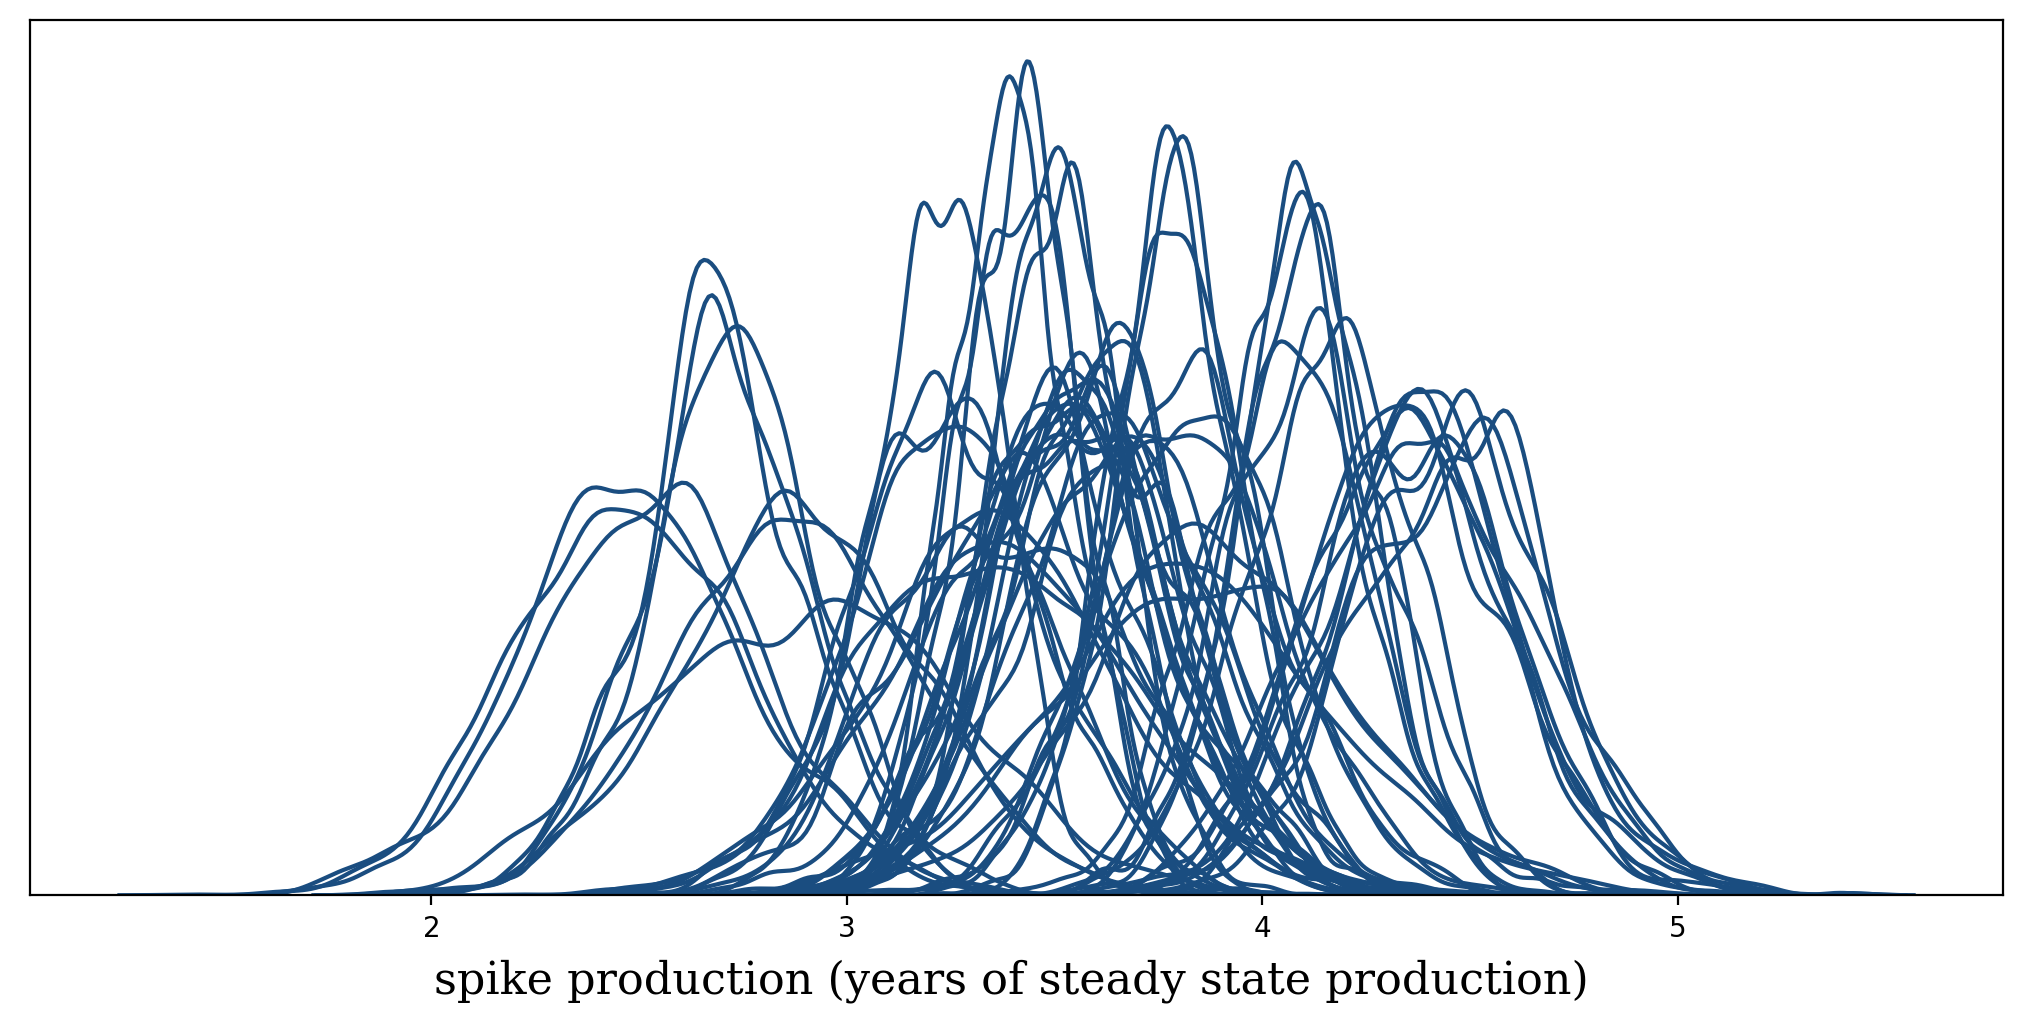

In [7]:
import seaborn as sns
fmt = ["-", "--", ":"]
fig = plt.figure(figsize=(10, 5), dpi=200, constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0, 0])
for i in range(0, len(events)):
    sns.kdeplot(Guttler14[:, i], color = (0.1, 0.3, 0.5, 0.3), ax=ax, clip=(0, 15)); 
    sns.kdeplot(Buntgen18[:, i], color = (0.1, 0.3, 0.5, 0.3), ax=ax, clip=(0, 15)); 
    sns.kdeplot(Brehm21[:, i], color = (0.1, 0.3, 0.5, 0.3), ax=ax, clip=(0, 15));
ax.axes.yaxis.set_visible(False)
fig.supxlabel("spike production (years of steady state production)", fontsize=16, fontfamily="serif", fontweight="roman");

Text(65, 3.8, 'YAM')

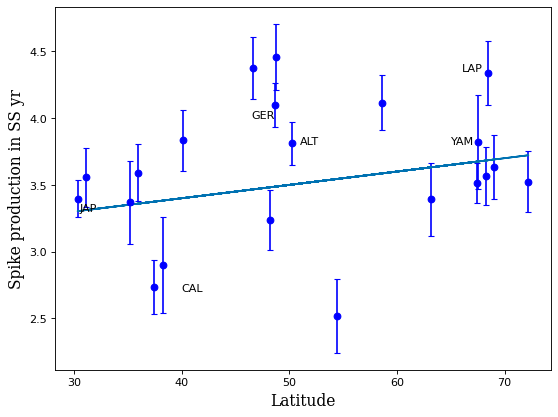

In [8]:
plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(np.array(lat), np.mean(Guttler14, axis=0), yerr=np.std(Guttler14, axis=0), fmt="bo", capsize=3)
plt.plot(np.array(lat),0.01*np.array(lat)+3)
plt.xlabel("Latitude", fontfamily="serif", fontsize=14)
plt.ylabel("Spike production in SS yr", fontfamily="serif", fontsize=14)
plt.text(30.5, 3.3, "JAP")
plt.text(66, 4.35, "LAP")
plt.text(40, 2.7, "CAL")
plt.text(51, 3.8, "ALT")
plt.text(46.5, 4, "GER")
plt.text(65, 3.8, "YAM")

In [9]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


In [10]:
from scipy.optimize import minimize
f_true =0.1
x, y, yerr = np.array(lat), np.mean(Guttler14, axis=0), np.std(Guttler14, axis=0)
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

x0 = np.linspace(x.min(),x.max(),1000)

Least-squares estimates:
m = 0.007 ± 0.003
b = 3.275 ± 0.175


In [11]:
yerr

array([0.15867351, 0.1645517 , 0.27282922, 0.24864339, 0.27984346,
       0.23188728, 0.14807694, 0.22458543, 0.20111195, 0.14079928,
       0.22924968, 0.21288081, 0.23134005, 0.24027593, 0.2028174 ,
       0.22199082, 0.35286946, 0.35991638, 0.30772016, 0.2177108 ,
       0.24192538])

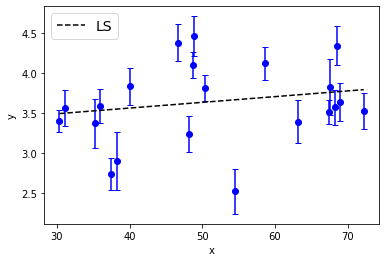

In [12]:

plt.errorbar(x, y, yerr=yerr, fmt="bo", capsize=3)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");


In [13]:

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.1, 3, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))


Maximum likelihood estimates:
m = 0.008
b = 3.223
f = 0.114


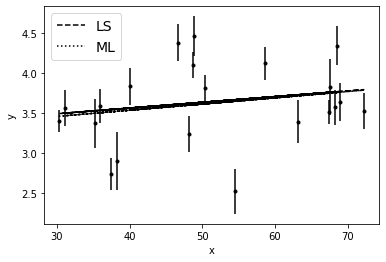

In [14]:

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x, m_true * x + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x, np.dot(np.vander(x, 2), w), "--k", label="LS")
plt.plot(x, np.dot(np.vander(x, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");



In [15]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf


In [16]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [17]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);


100%|██████████████████████████████████████| 5000/5000 [00:07<00:00, 660.18it/s]


In [18]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)


(10432, 3)


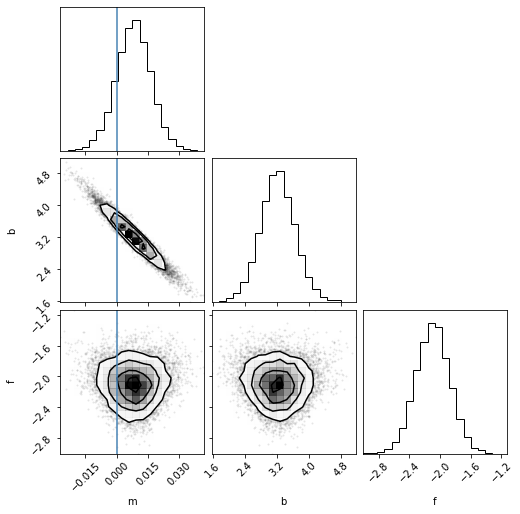

In [19]:
import corner

fig = corner.corner(
    flat_samples, labels=['m','b','f'],truths=[0,np.nan,np.nan]
);


WARNING[2022-02-20 12:32:34,229]: No handles with labels found to put in legend.


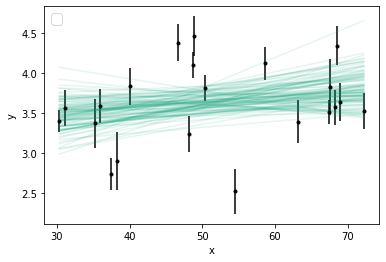

In [20]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");


In [21]:
nsamps = 1001
all_models = np.zeros((nsamps,len(x0)))

inds = np.random.randint(len(flat_samples), size=nsamps)
for j, ind in enumerate(inds):
    sample = flat_samples[ind]
    all_models[j,:] = np.dot(np.vander(x0, 2), sample[:2])


In [38]:
lower, mid, upper = np.percentile(all_models,(16,50,84),axis=0)

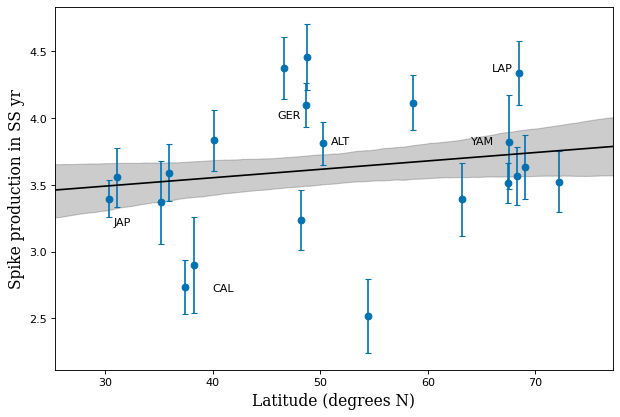

In [39]:
plt.figure(figsize=(9, 6), dpi=80)

x0 = np.linspace(x.min()-5,x.max()+5,1000)

plt.errorbar(np.array(lat), np.mean(Guttler14, axis=0), yerr=np.std(Guttler14, axis=0), fmt="o", capsize=3)
plt.plot(x0,all_models.mean(axis=0),color='k')
plt.fill_between(x0,lower,upper,alpha=0.2,color='k')
plt.xlabel("Latitude (degrees N)", fontfamily="serif", fontsize=14)
plt.ylabel("Spike production in SS yr", fontfamily="serif", fontsize=14)
plt.text(30.75, 3.2, "JAP")
plt.text(66, 4.35, "LAP")
plt.text(40, 2.7, "CAL")
plt.text(51, 3.8, "ALT")
plt.text(46.0, 4, "GER")
plt.text(64, 3.8, "YAM")
plt.xlim(x0.min(),x0.max())
plt.savefig('latitude_trend.pdf',bbox_inches='tight')

In [28]:
lines = np.percentile(flat_samples[:,0],(16,50,84))
print('%.1f +- %.1f' % (1e3*np.mean(flat_samples[:,0]), 1e3*np.std(flat_samples[:,0])))

7.9 +- 8.6


In [ ]:
lines = np.percentile(flat_samples[:,0],(16,50,84))

plt.hist(flat_samples[:,0],bins=100);

for line in lines:
    plt.axvline(line)